In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import os

In [2]:
import sys
sys.path.append('..')

In [3]:
import mysecrets
import config
import fetch_from_cluster
import catalogmanager
import sqlite_db_utils

/Users/nikhilsrajan/NASA-Harvest/project/fetch_satdata/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
s2_satellite_catalog_gdf = \
fetch_from_cluster.load_satellite_sentinel2_catalog(
    sshcreds = mysecrets.SSH_UMD,
    satellite_folderpath = config.FOLDERPATH_SATELLITE,
    overwrite = True,
)

In [5]:
s2_satellite_catalog_gdf.shape

(12427, 9)

In [6]:
s2_satellite_catalog_gdf.columns

Index(['id', 'satellite', 'timestamp', 's3url', 'local_folderpath', 'files',
       'last_update', 'cloud_cover', 'geometry'],
      dtype='object')

In [7]:
s2_satellite_catalog_gdf['last_update']

0       2024-08-20 13:54:40.022000+00:00
1       2024-08-20 13:54:40.023000+00:00
2       2024-08-20 13:54:40.025000+00:00
3       2024-08-20 13:54:40.027000+00:00
4       2024-08-20 13:54:40.028000+00:00
                      ...               
12422   2025-02-11 13:31:40.879000+00:00
12423   2025-02-11 13:31:40.883000+00:00
12424   2025-02-11 13:32:04.646000+00:00
12425   2025-02-11 13:32:25.443000+00:00
12426   2025-02-11 13:34:08.774000+00:00
Name: last_update, Length: 12427, dtype: datetime64[ms, UTC]

In [8]:
sqlite_db_utils.ts_to_str(s2_satellite_catalog_gdf['last_update'][0])

'2024-08-20T13:54:40.022Z'

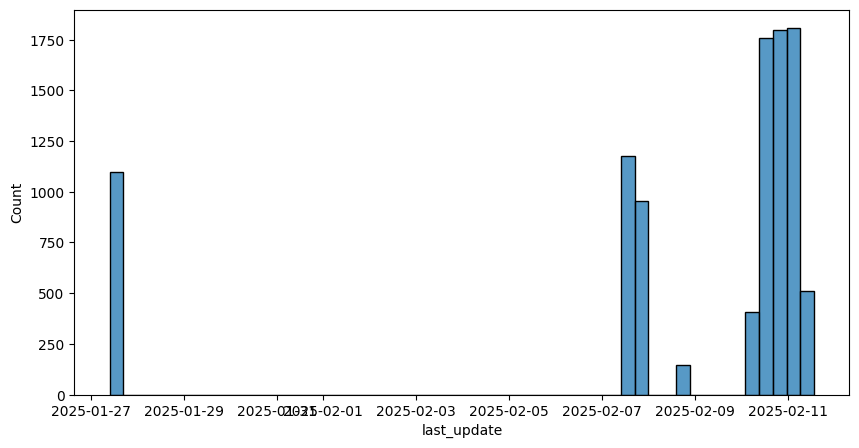

In [9]:
scale = 5
aspect_ratio = 2
fig, ax = plt.subplots(figsize=(scale*aspect_ratio, scale))

g = sns.histplot(
    data = s2_satellite_catalog_gdf[
        s2_satellite_catalog_gdf['last_update'] >= catalogmanager.dt2ts(dt=datetime.datetime(2025, 1, 1))
    ],
    x = 'last_update',
)

### geojson to db

In [10]:
catalog_filepath = fetch_from_cluster.remotepath_to_localpath(
    remotepath = fetch_from_cluster.FILEPATH_SATELLITE_SENTINEL2_CATALOG,
    remote_root_path = fetch_from_cluster.FOLDERPATH_SATELLITE,
    local_root_path = config.FOLDERPATH_SATELLITE,
)
catalog_filepath

'/Users/nikhilsrajan/NASA-Harvest/project/fetch_satdata/notebooks/../data/satellite/Sentinel-2/catalog.geojson'

In [11]:
db_path = catalog_filepath.replace('.geojson', '.db')
db_path

'/Users/nikhilsrajan/NASA-Harvest/project/fetch_satdata/notebooks/../data/satellite/Sentinel-2/catalog.db'

In [12]:
col_type_dict = {
    'id': 'TEXT UNIQUE',
    'satellite': 'TEXT',
    'timestamp': 'TEXT',
    's3url': 'TEXT',
    'local_folderpath': 'TEXT',
    'files': 'TEXT',
    'last_update': 'TEXT',
    'cloud_cover': 'REAL',
    'geometry': 'TEXT',
}

s2l2a_table = 'sentinel-2-l2a'
s2l1c_table = 'sentinel-2-l1c'

In [13]:
if os.path.exists(db_path):
    os.remove(db_path)

sqlite_db_utils.create_db(
    database = db_path,
    db_structure = {
        s2l2a_table : col_type_dict,
        s2l1c_table : col_type_dict, 
    },
    id_col = 'id',
)

In [14]:
for table in [s2l2a_table, s2l1c_table]:
    _rows = [
        sqlite_db_utils.gpd_to_sql_row(row_dict=row)
        for index, row in s2_satellite_catalog_gdf.iterrows()
        if row['satellite'] == table
    ]

    sqlite_db_utils.insert_rows_to_db(
        database = db_path,
        table = table,
        data_dicts = _rows,
    )

    del _rows

In [18]:
sqlite_db_utils.fetch_rows_from_db(
    database = db_path,
    table = s2l2a_table,
)

,id,satellite,timestamp,s3url,local_folderpath,files,last_update,cloud_cover,geometry
0,S2A_MSIL2A_20200705T074621_N0500_R135_T37PBL_2...,sentinel-2-l2a,2020-07-05 08:07:30.846000+00:00,s3://EODATA/Sentinel-2/MSI/L2A_N0500/2020/07/0...,/gpfs/data1/cmongp2/sasirajann/fetch_satdata/d...,"B01.jp2,B03.jp2,B07.jp2,B11.jp2,B09.jp2,SCL.jp...",2025-02-07 10:00:56.636000+00:00,84.35,"MULTIPOLYGON (((36.26397 9.94021, 37.26487 9.9..."
1,S2B_MSIL2A_20200508T073609_N0500_R092_T37NEH_2...,sentinel-2-l2a,2020-05-08 07:58:02.654000+00:00,s3://EODATA/Sentinel-2/MSI/L2A_N0500/2020/05/0...,/gpfs/data1/cmongp2/sasirajann/fetch_satdata/d...,"B01.jp2,B03.jp2,B07.jp2,B11.jp2,B09.jp2,SCL.jp...",2025-02-07 10:00:56.638000+00:00,84.83,"MULTIPOLYGON (((38.99983 7.23782, 39.99438 7.2..."
2,S2A_MSIL2A_20200725T074621_N0500_R135_T37PBK_2...,sentinel-2-l2a,2020-07-25 08:07:46.165000+00:00,s3://EODATA/Sentinel-2/MSI/L2A_N0500/2020/07/2...,/gpfs/data1/cmongp2/sasirajann/fetch_satdata/d...,"B01.jp2,B03.jp2,B07.jp2,B11.jp2,B09.jp2,SCL.jp...",2025-02-07 10:00:56.640000+00:00,66.04,"MULTIPOLYGON (((36.27113 9.03658, 37.26941 9.0..."
3,S2A_MSIL2A_20200722T073621_N0500_R092_T37NDJ_2...,sentinel-2-l2a,2020-07-22 07:57:58.589000+00:00,s3://EODATA/Sentinel-2/MSI/L2A_N0500/2020/07/2...,/gpfs/data1/cmongp2/sasirajann/fetch_satdata/d...,"B01.jp2,B03.jp2,B07.jp2,B11.jp2,B09.jp2,SCL.jp...",2025-02-07 10:00:56.642000+00:00,96.01,"MULTIPOLYGON (((38.09192 8.14101, 39.08859 8.1..."
4,S2B_MSIL2A_20200518T073609_N0500_R092_T37PDP_2...,sentinel-2-l2a,2020-05-18 07:56:40.896000+00:00,s3://EODATA/Sentinel-2/MSI/L2A_N0500/2020/05/1...,/gpfs/data1/cmongp2/sasirajann/fetch_satdata/d...,"B01.jp2,B03.jp2,B07.jp2,B11.jp2,B09.jp2,SCL.jp...",2025-02-07 10:00:56.644000+00:00,77.57,"MULTIPOLYGON (((38.96927 12.66454, 39.08987 12..."
...,...,...,...,...,...,...,...,...,...
8559,S2A_MSIL2A_20190704T075611_N0500_R035_T36PYR_2...,sentinel-2-l2a,2019-07-04 08:17:31.315000+00:00,s3://EODATA/Sentinel-2/MSI/L2A_N0500/2019/07/0...,/gpfs/data1/cmongp2/sasirajann/fetch_satdata/d...,"MTD_TL.xml,B07.jp2,B05.jp2,B03.jp2,B08.jp2,B12...",2025-02-11 13:31:40.879000+00:00,36.79,"MULTIPOLYGON (((34.82395 9.94642, 35.82478 9.9..."
8560,S2B_MSIL2A_20220108T074209_N0510_R092_T37PDQ_2...,sentinel-2-l2a,2022-01-08 07:56:25.456000+00:00,s3://EODATA/Sentinel-2/MSI/L2A_N0500/2022/01/0...,/gpfs/data1/cmongp2/sasirajann/fetch_satdata/d...,"MTD_TL.xml,B07.jp2,B05.jp2,B03.jp2,B08.jp2,B12...",2025-02-11 13:31:40.883000+00:00,1.07,"MULTIPOLYGON (((39.08892 12.57556, 38.94461 12..."
8561,S2A_MSIL2A_20190525T075611_N0500_R035_T36PXS_2...,sentinel-2-l2a,2019-05-25 08:17:18.420000+00:00,s3://EODATA/Sentinel-2/MSI/L2A_N0500/2019/05/2...,/gpfs/data1/cmongp2/sasirajann/fetch_satdata/d...,"MTD_TL.xml,B07.jp2,B05.jp2,B03.jp2,B08.jp2,B12...",2025-02-11 13:32:04.646000+00:00,99.18,"MULTIPOLYGON (((33.91491 10.85411, 34.91916 10..."
8562,S2A_MSIL2A_20190405T075611_N0500_R035_T36PZR_2...,sentinel-2-l2a,2019-04-05 08:17:23.003000+00:00,s3://EODATA/Sentinel-2/MSI/L2A_N0500/2019/04/0...,/gpfs/data1/cmongp2/sasirajann/fetch_satdata/d...,"MTD_TL.xml,B07.jp2,B05.jp2,B03.jp2,B08.jp2,B12...",2025-02-11 13:32:25.443000+00:00,0.28,"MULTIPOLYGON (((35.73568 9.94021, 36.05835 9.9..."


In [17]:
sqlite_db_utils.fetch_rows_from_db(
    database = db_path,
    table = s2l1c_table,
)

,id,satellite,timestamp,s3url,local_folderpath,files,last_update,cloud_cover,geometry
0,S2A_MSIL1C_20211224T074331_N0500_R092_T37PDK_2...,sentinel-2-l1c,2021-12-24 07:57:40.190000+00:00,s3://EODATA/Sentinel-2/MSI/L1C_N0500/2021/12/2...,/gpfs/data1/cmongp2/sasirajann/fetch_satdata/d...,"B10.jp2,B09.jp2,B04.jp2,B8A.jp2,B05.jp2,B01.jp...",2024-08-20 13:54:40.022000+00:00,6.12,"MULTIPOLYGON (((38.16166 9.04578, 39.0888 9.04..."
1,S2B_MSIL1C_20210413T073609_N0500_R092_T37PEK_2...,sentinel-2-l1c,2021-04-13 07:57:32.025000+00:00,s3://EODATA/Sentinel-2/MSI/L1C_N0500/2021/04/1...,/gpfs/data1/cmongp2/sasirajann/fetch_satdata/d...,"B10.jp2,B09.jp2,B04.jp2,B8A.jp2,B05.jp2,B01.jp...",2024-08-20 13:54:40.023000+00:00,18.33,"MULTIPOLYGON (((38.99983 9.04673, 39.99885 9.0..."
2,S2A_MSIL1C_20211114T074151_N0500_R092_T37PDK_2...,sentinel-2-l1c,2021-11-14 07:57:40.238000+00:00,s3://EODATA/Sentinel-2/MSI/L1C_N0500/2021/11/1...,/gpfs/data1/cmongp2/sasirajann/fetch_satdata/d...,"B10.jp2,B09.jp2,B04.jp2,B8A.jp2,B05.jp2,B01.jp...",2024-08-20 13:54:40.025000+00:00,7.87,"MULTIPOLYGON (((38.16657 9.04579, 39.0888 9.04..."
3,S2A_MSIL1C_20211204T074301_N0500_R092_T37NEJ_2...,sentinel-2-l1c,2021-12-04 07:57:49.492000+00:00,s3://EODATA/Sentinel-2/MSI/L1C_N0500/2021/12/0...,/gpfs/data1/cmongp2/sasirajann/fetch_satdata/d...,"B10.jp2,B09.jp2,B04.jp2,B8A.jp2,B05.jp2,B01.jp...",2024-08-20 13:54:40.027000+00:00,0.14,"MULTIPOLYGON (((38.99983 8.14202, 39.99648 8.1..."
4,S2B_MSIL1C_20211129T074149_N0500_R092_T37NDJ_2...,sentinel-2-l1c,2021-11-29 07:57:48.816000+00:00,s3://EODATA/Sentinel-2/MSI/L1C_N0500/2021/11/2...,/gpfs/data1/cmongp2/sasirajann/fetch_satdata/d...,"B10.jp2,B09.jp2,B04.jp2,B8A.jp2,B05.jp2,B01.jp...",2024-08-20 13:54:40.028000+00:00,4.87,"MULTIPOLYGON (((38.09192 8.14101, 39.08859 8.1..."
...,...,...,...,...,...,...,...,...,...
3858,S2A_MSIL1C_20191006T073801_N0500_R092_T37NDH_2...,sentinel-2-l1c,2019-10-06 07:58:10.246000+00:00,s3://EODATA/Sentinel-2/MSI/L1C_N0500/2019/10/0...,/gpfs/data1/cmongp2/sasirajann/fetch_satdata/d...,"B09.jp2,B06.jp2,MTD_TL.xml,B03.jp2,B04.jp2,B01...",2025-01-27 13:46:11.388000+00:00,62.39,"MULTIPOLYGON (((38.09384 7.23692, 39.0884 7.23..."
3859,S2A_MSIL1C_20190621T074621_N0500_R135_T37NBH_2...,sentinel-2-l1c,2019-06-21 08:08:13.611000+00:00,s3://EODATA/Sentinel-2/MSI/L1C_N0500/2019/06/2...,/gpfs/data1/cmongp2/sasirajann/fetch_satdata/d...,"B09.jp2,B06.jp2,MTD_TL.xml,B03.jp2,B04.jp2,B01...",2025-01-27 13:46:59.394000+00:00,32.83,"MULTIPOLYGON (((36.28333 7.22972, 37.27716 7.2..."
3860,S2B_MSIL1C_20191004T074749_N0500_R135_T37NCJ_2...,sentinel-2-l1c,2019-10-04 08:07:52.217000+00:00,s3://EODATA/Sentinel-2/MSI/L1C_N0500/2019/10/0...,/gpfs/data1/cmongp2/sasirajann/fetch_satdata/d...,"B09.jp2,B06.jp2,MTD_TL.xml,B03.jp2,B04.jp2,B01...",2025-01-27 13:46:59.396000+00:00,64.33,"MULTIPOLYGON (((37.18479 8.13797, 38.16667 8.1..."
3861,S2A_MSIL1C_20190731T074621_N0500_R135_T37NCH_2...,sentinel-2-l1c,2019-07-31 08:08:10.699000+00:00,s3://EODATA/Sentinel-2/MSI/L1C_N0500/2019/07/3...,/gpfs/data1/cmongp2/sasirajann/fetch_satdata/d...,"B09.jp2,B06.jp2,MTD_TL.xml,B03.jp2,B04.jp2,B01...",2025-01-27 13:46:59.399000+00:00,99.69,"MULTIPOLYGON (((37.18863 7.23422, 37.95432 7.2..."


In [15]:
db_gdf = sqlite_db_utils.fetch_rows_from_db(
    database = db_path,
    table = s2l1c_table,
    # columns = ['id', 'geometry']
)

In [16]:
db_gdf['satellite'].value_counts()

satellite
sentinel-2-l1c    3863
Name: count, dtype: int64

In [ ]:
selected_id = s2_satellite_catalog_gdf['id'][0]
selected_id

In [ ]:
selected_id = s2_satellite_catalog_gdf['id'][0]
selected_id

In [ ]:
satellite_filepaths = fetch_from_cluster.download_sentinel2_satellite(
    id = selected_id,
    sshcreds = mysecrets.SSH_UMD,
    satellite_folderpath = config.FOLDERPATH_SATELLITE,
)

In [ ]:
satellite_filepaths